# HW 5: Working with Strings: Analyzing NTSB Aviation Incident Narratives
Submitted by: Gideon Tay\
My UNI: gt2528\
Contact me at: gideon.tay@columbia.edu

In [1]:
# Import Python libraries needed for this homework
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Read csv file, stored in a data subdirectory
df = pd.read_csv('data/ntsb_narratives_2021_2024.csv')

# See first few rows to get a sense of the dataframe
df.head(3)

,ev_id,year,narrative
0,20080219X00203,2022,During a cross country flight the pilot of a C...
1,20080514X00667,2024,This incident occurred when United Airlines fl...
2,20080416X00494,2022,"The pilot planed a flight from Frederick, Mary..."


## 1. Engine Incidents and Failures### 1a. Extracting Engine IncidentsIdentify narratives mentioning “engine” (or "engines"). Create a boolean column `engine` to mark such incidents.



In [2]:
# Create the boolean 'engine' column
df['engine'] = df['narrative'].str.contains(
    r'\bengines?\b',     # Regex for 'engine' or 'engines', optional 's'
    case=False, na=False # Case-insensitive search, ignore empty rows
)

# Show the first few rows of the updated dataframe with 'engine' column
df.head(3)

,ev_id,year,narrative,engine
0,20080219X00203,2022,During a cross country flight the pilot of a C...,True
1,20080514X00667,2024,This incident occurred when United Airlines fl...,False
2,20080416X00494,2022,"The pilot planed a flight from Frederick, Mary...",True


In [3]:
# Count the number of engine-related narratives
engine_related_count = df['engine'].sum()

# Display the count of engine-related narratives
print(f"Number of engine-related narratives: {engine_related_count}")

Number of engine-related narratives: 2940


### 1b. Use regex to extract engine failure narratives, differentiating them from general engine incidents
We consider whether the two words before or after the term “engine” (or its variations) include terms suggesting engine failure. Our regular expression works as follows:

- Find 'engine' (and its variations). Then, check if the next word is some variation of 'fail' or 'stop'. If not, skip that word, and check the following word again.
    - Captures: `engine failure`, `Engine stopped`, `engine then failed`, `engines suddenly stopped`, `engine breakdown`, `engine shutdown`, `engine blow up`.
- Find 'fail' or 'stop' (and their variations). Then, check if the next word is some variation of 'engine'. If not, skip that word, and check the following word again.
    - Captures: `failed engine`, `stopped the engine`, `failure of engines`, `blowing engine`, `blown engine`

Let us first define the regular expression:


In [4]:
# Regex for failure-related terms
# Step 1: Define failure-related terms with detailed comments
failure_terms = r'''
    fail(ure|ed|s)?|      # Match 'fail', 'failure', 'failed', 'fails'
    stop(page|ped|s)?|    # Match 'stop', 'stoppage' 'stopped', 'stops'
    (break|shut)down|     # Match 'breakdown', 'shutdown'
    blow(ing|n)?          # Match 'blow', 'blowing', 'blown'
'''

# Multi-line regex for engine failure
engine_failure_pattern = rf'''
    \bengines?\b           # Match 'engine' or 'engines' with word boundaries, optional 's'
    \s*                    # Match zero or more spaces
    (\b\w+\b\s+)?          # Match an optional word after 'engine' or 'engines'
    \b({failure_terms})\b  # Match failure-related terms
    |                      # OR
    \b({failure_terms})\b  # Match failure-related terms
    \s*                    # Match zero or more spaces
    (\b\w+\b\s+)?          # Match an optional word before 'engine' or 'engines'
    \bengines?\b           # Match 'engine' or 'engines'
'''

Using this regular expression, create a boolean `engine_failure` column that marks cases of engine failure as `True`. Finally, we present summary statistics.

In [5]:
# Create a boolean column 'engine_failure' for engine failures
df['engine_failure'] = df['narrative'].str.contains(
    engine_failure_pattern, # Regex pattern of interest           
    na=False,               # Ignore empty rows
    # VERBOSE: Ignore whitespace/ comments in multi-line regex
    # IGNORECASE: Case-insensitive search, account for capitalization
    flags=re.VERBOSE | re.IGNORECASE
)

# Calculate summary statistics
engine_related_proportion = df['engine'].sum() / len(df)
engine_failure_proportion = (
    df['engine_failure'].sum() / df['engine'].sum()
    if df['engine'].sum() > 0
    else 0                    # avoid ZeroDivisionError if df['engine'].sum()==0
)

# Print summary statistics
print(
    f"Proportion of narratives mentioning engine: "
    f"{engine_related_proportion:.2%}" # :.2% formats result as 2d.p. percentage
)
print(
    f"Proportion of engine-related narratives identified as engine failures: "
    f"{engine_failure_proportion:.2%}"
)

C:\Users\gideo\AppData\Local\Temp\ipykernel_12504\2194412630.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['engine_failure'] = df['narrative'].str.contains(


Proportion of narratives mentioning engine: 49.75%
Proportion of engine-related narratives identified as engine failures: 7.65%


### 1c. Display 10 random entries and discuss how the identification process could be improved

We first define a function `get_engine_context` that extracts the two words before and after the mention of 'engine' or 'engines'. Then, we apply it to the dataset. Finally, we display 10 random entries with `engine_context`, `engine`, and `engine_failure` columns.

In [6]:
# Function to extract two words before and after the mention of 'engine'
def get_engine_context(narrative):
    pattern = r'''
    (
    (?:\b\w+\b\s+){0,2}     # Extract 2 words before, word character \w with word boundaries \b
    \bengines?\b            # Match 'engine' or 'engines' with word boundaries
    \s*                     # Zero or more spaces before next word
    (?:\b\w+\b\s+){0,2}     # Extract 2 words after
    )
    '''
    matches = re.findall(
        pattern, narrative, 
        flags=re.IGNORECASE | re.VERBOSE # case-insensitive, verbose for multiline regex
    )
    return matches if matches else None

# Extract the context for each narrative in the dataframe
df['engine_context'] = df['narrative'].apply(get_engine_context)

# Randomly select 10 entries from the DataFrame
sample_df = df.sample(n=10, random_state=1)

# Display the sample DataFrame with engine context and new variables
sample_df[['engine_context', 'engine', 'engine_failure']]

,engine_context,engine,engine_failure
4519,None,False,False
3147,"[s engine lost total , and the engine was , pr...",True,False
3037,[of the engine and its ],True,False
712,None,False,False
5410,None,False,False
2126,"[but the engine did not , down the engine, sta...",True,False
5064,None,False,False
2639,None,False,False
3821,None,False,False
416,"[saw the engine power winding , The engine exp...",True,False


It is a bit hard to read the `engine_context` column since their entries are long. This is because 'engine' or 'engines' are often mentioned multiple times in the narrative. For rows where `engine_context` has contents, I wrote some code to display results more nicely for readability:

In [7]:
# Create a function to format the output for display
def format_display(row):
    engine_context = row['engine_context']
    engine = row['engine']
    engine_failure = row['engine_failure']
    return (f"Context:\n{engine_context}\n"
            f"Engine Related: {engine}\n"
            f"Engine Failure: {engine_failure}"
    )

# Apply the function to each row in the sample DataFrame and create a new formatted list
formatted_output = sample_df[sample_df['engine']].apply(format_display, axis=1)

# Print each formatted output
for output in formatted_output:
    print(output)
    print('-' * 40)  # Separator for better readability

Context:
['s engine lost total ', 'and the engine was ', 'prevented an engine test ', 'of the engine noted that ', 'The engine and fuel ', 'loss of engine ']
Engine Related: True
Engine Failure: False
----------------------------------------
Context:
['of the engine and its ']
Engine Related: True
Engine Failure: False
----------------------------------------
Context:
['but the engine did not ', 'down the engine', 'started the engine and departed ', 'when the engine power decreased ', 'that the engine was not ', 'that the engine experienced a ']
Engine Related: True
Engine Failure: False
----------------------------------------
Context:
['saw the engine power winding ', 'The engine experienced a ']
Engine Related: True
Engine Failure: False
----------------------------------------


Now, we briefly discuss potential issues and improvements of the identification process.

**Potential Issue 1: False positives**
- **Coincidental matching**: the regex may incorrectly flag some entries that do not pertain to engine failures if we conincidentally find the failure terms near to 'engine' or 'engines' but used in a different context (e.g. "the engine didn't fail").

**Potential Issues 2: Missed Entries**
- **Language variation**: the use of more complex descriptions, synonyms, or informal language (e.g. "the engine is not working"), may not be captured if they do not strictly follow the predefined terms in the regex.
- **Long phrasing**: we only looked at the 2 terms before and after the word 'engine' or 'engines'. We miss longer phrasing where failure terms are found outside our 2 word search radius. (e.g. "the engine slowed and eventually failed").

**Potential Improvements**

- **Contextual Analysis**: Incorporating more sophisticated natural language processing (NLP) techniques could help in better understanding the context in which "engine" is mentioned to reduce false positives and reduce missed entries.

- **More terms to capture failure**: the list of failure-related terms can be expanded and curated based on industry-specific jargon to improve the accuracy of identification. For example, an engine malfunction may be distinct from an engine failure.

## 2. Extracting the Time of Day
### 2a. Extract the time of day from narratives

Before we define the regular expression for time of day, we realize that regular expressions attempting to capture the no-colon 24-hour format may unintentionally capture years instead. For example, 2020 may be the year 2020, or the time 8:20 PM. To avoid that, I want to first find out what are the likely years that we may find in narrative, so we can be on the lookout to avoid them when defining our time of day regular expression.

In [8]:
# Find all unqiue years of the incident reports in our dataset
unique_years = sorted(df['year'].unique())
print(unique_years)

[2021, 2022, 2023, 2024]


The narrative may include the year of the incident report, which ranges from 2021-2024 in our dataset. There are also other contexts in which it may refer to years, such as date of report modification (year '2015' mentioned in row 18 and 256), history of the aircraft in the incident (year '2020' mentioned in row 378), or dates of similar past incidents. To be safe, let us ignore no-colon 24-hour times of 2000 to 2024 (8PM to 8:24PM), as they may refer to years rather than times.

**Explaining our regular expression design**

Our regex captures the following time types: 
- '0940' (24-hour format without colon)
- '14:30' (24-hour format with colon)
- '2:15 PM' (12-hour format with space before AM/PM)
- '11:00AM' (12-hour format without space before AM/PM)
- '09:10 AM', '02:15PM' (12-hour format with 0 in front of single digits)
- '4 PM', '4PM' (12-hour format without minutes)
- '4:00pm' (12-hour format with non-capitalized AM/PM)

I explicitly chose to define the 12h and 24h format regex separately rather than do some combined search like `(?P<hours>(0?[0-9]|1[0-9]|2[0-3]))(?P<minutes>:?[0-5][0-9])(?P<period>\s?[AP]M)?`, as that would produce false or nonsense matches arising from weird combinations of the 12h and 24h time format. For example, the number '940', nonsense value '1415 AM', and ambiguous '9:40' would have matched if we took the other approach.

As explained above, we want to ignore 2000 to 2024, as it may refer to years instead of 8PM to 8:24PM in the no-colon 24-hour time format. For simplicity, when defining our regular expression, we simply ignore all 2000 to 2059 cases. Note that if these times are shown in other formats, it will still be captured by our regular expression. For example, 8:00PM to 8:59PM and 20:00 to 20:59 will still be captured.

**Explaining negative lookback/ lookahead**

We use a negative lookback and lookahead to avoid false matches. They ensure that the time pattern is not preceded or followed by a digit. This avoids cases where long non-time numbers are captured (e.g. 'the plane was at 10940 feet'), since '10940' contains '0940' that would have matched without the negative lookback. Similarly, '14300 feet' contains '1430' that would have matched without then negative lookahead.

We used negative lookback and lookahead of digits instead of enforcing a space before and after (`\s`) since we do not want to miss out on cases where there may be missing spaces before or after the time, (e.g. 'the time:0940').

In [9]:
# Regex pattern for time
time_pattern = r'''
(?<!\d)(                        # Negative lookback: not preceded by a digit
    (?P<time_12h>               # Named capturing group for 12-hour format
        (0?[0-9]|1[0-2])        # Matches hours 00-09, 0-9, or 10-12
        (:[0-5][0-9])?          # Matches minutes 00-59 or :00-:59 (optional)
        \s?[APap][Mm]           # Matches 'PM', 'AM', 'pm', 'am', ' PM', ' AM'
    )
    |
    (?P<time_24h_colon>         # Named group for 24-hour format w/ colon
        (0[0-9]|1[0-9]|2[0-3])  # Matches hours 00-09, 10-19, or 20-23
        (:[0-5][0-9])           # Matches minutes :00 to :59 
    )
    |
    (?P<time_24h_no_colon>      # Named group for 24-hour format w/o colon
        (0[0-9]|1[0-9]|2[1-3])  # Matches hours 00-09, 10-19, or 21-23. Ignore 20
        ([0-5][0-9])            # Matches minutes 00 to 59 (no colon)
    )
)(?!\d)                         # Negative lookahead: not followed by a digit
'''

Next, let's extract the time and create a new column `time_of_day` that stores the time in 24-hour format with colon. For cases where multiple times are written in the narrative, we will only care about the first instance, as we use `re.search()`.

Below, we define an `extract_time()` function to find matches of the `time_pattern` regex we defined above in the narrative column, and to convert these matches into the 24-hour time formate with colon. We then apply this function and show some sample results.

In [10]:
# Function to extract time using re.search and return in HH:MM 24h-format
def extract_time(narrative):
    # Search for first occurence of a time_pattern in narrative
    match = re.search(time_pattern, narrative, re.VERBOSE)
    
    # If you find a match for time_pattern in narrative
    if match:
        # If 12-hour format is found, convert to 24-hour w/ colon format
        if match.group('time_12h'):  
            time_str = match.group('time_12h')
            
            # Separate the AM/PM part and store as lower case
            am_pm = time_str[-2:].lower()  # Get the last two characters (am/pm)
            time_str = time_str[:-2].strip()  # Remove AM/PM part from the time
            
            # Extract hour and minute from time_str (AM/PM already removed)
            # If minutes missing (eg. 3PM), assign 00 to minutes
            hour, minute = (
                time_str.split(':')  # Split along ':' and returns list
                + ['00']  # add '00' to list, is 2nd element if no minute
            )[:2]  # Only consider first 2 element in the list
            
            # Convert to 24-hour format
            hour = int(hour) # Convert datatype to integer for manipulation
            # If PM and not already 12pm, add 12 to hour (eg. 1:00PM to 13:00)
            if am_pm == 'pm' and hour != 12: 
                hour += 12
            # If AM and hour is 12, set hour to 0 (eg. 12:10AM to 00:10)
            elif am_pm == 'am' and hour == 12:
                hour = 0
                
            # Return as 24h HH:MM format
            # :02 pads hours with 0 if less than 2 digits (eg. 3 to 03)
            return (f"{hour:02}:{minute}")

        # If 24-hour colon format is found, return as is
        elif match.group('time_24h_colon'):  
            return match.group('time_24h_colon')

        # If 24-hour no colon format is found, add a colon
        elif match.group('time_24h_no_colon'): 
            time_str = match.group('time_24h_no_colon')
            hour = time_str[:2]  # First two characters for hour
            minute = time_str[2:]  # Remaining characters for minute
            return (f"{int(hour):02}:{minute}")
    
    # If no match for time_pattern is found in narrative, return None
    return None

# Apply the function to the narrative column
df['time_of_day'] = df['narrative'].apply(extract_time)

# Show the first 5 entries where time_of_day is successfully extracted
selected_columns = ['ev_id', 'year', 'narrative', 'time_of_day']
df[df['time_of_day'].notnull()][selected_columns].head(5)

,ev_id,year,narrative,time_of_day
4,20080222X00229,2024,go! flight 1002 departed for its destination a...,10:02
5,20080227X00237,2023,"** This report was modified on July 5, 2023. P...",15:40
8,20080413X00464,2023,"The Boeing 737-700 was at an altitude 30,0000 ...",00:00
9,20080311X00297,2021,The Safety Board's full report is available at...,09:05
11,20080509X00640,2024,NTSB materials laboratory examined the wing-si...,00:27


Lastly, we provide a summary statistic on how many narratives contain a time mention:

In [11]:
# Provide a summary statistic on how many narratives contain a time mention
time_mentions_count = df['time_of_day'].notnull().sum()
print(f'Total Narratives: {len(df)}')
print(f'Narratives Containing a Time Mention: {time_mentions_count}')
print(
    f'Percentage of Narratives Containing a Time Mention: '
    f'{time_mentions_count/ len(df):.2%}'
)

Total Narratives: 5909
Narratives Containing a Time Mention: 222
Percentage of Narratives Containing a Time Mention: 3.76%


### 2b. Relationship between time of day and engine failures
We first define a function to extract hour from our `time_of_day` column by looking at the first 2 digits. We then store the hour in a new `hour` column. Next, we count the cases of engine failures, grouped by the hour. To get the proportion per hour, we divide this count by the total number of engine failure incidents in the dataframe. 

In [12]:
# Define a function to extract hour from time_of_day
def extract_hour(time_of_day):
    if not time_of_day: # handles None or empty string
        return None
    else:
        return int(time_of_day[:2]) # get the first 2 digits (the hours)

# Apply extract_hour function to produce hour column
df['hour'] = df['time_of_day'].apply(extract_hour)

# Count cases of engine failure, grouped by the hour of the incident
engine_failure_by_hour = df[df['engine_failure']].groupby('hour') \
                        .size().reset_index(name='engine_failure_count')

# Ensure all hours are represented in engine failure count
all_hours = pd.DataFrame({'hour': range(24)})
engine_failure_by_hour = all_hours.merge(
    engine_failure_by_hour, on='hour', how='left'
).fillna(0)

# Get total number of engine failure incidents
total_engine_failure_count = df['engine_failure'].sum()

# Get proportion of engine failure by hour
engine_failure_by_hour['proportion'] = (
    engine_failure_by_hour['engine_failure_count'] / total_engine_failure_count
)

# Display engine failure by hour (count and proportion)
engine_failure_by_hour

,hour,engine_failure_count,proportion
0,0,0.0,0.000000
1,1,0.0,0.000000
2,2,0.0,0.000000
3,3,0.0,0.000000
4,4,0.0,0.000000
5,5,0.0,0.000000
6,6,0.0,0.000000
7,7,0.0,0.000000
8,8,0.0,0.000000
9,9,0.0,0.000000


Let's plot this data as a bar plot:

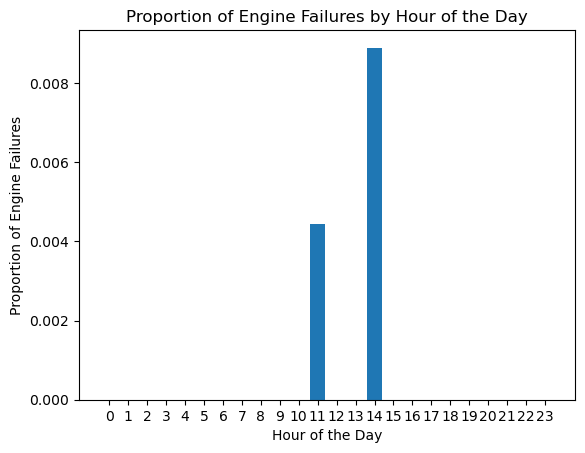

In [13]:
# Plot proportion on a bar graph
plt.bar(engine_failure_by_hour['hour'], engine_failure_by_hour['proportion'])
plt.xlabel('Hour of the Day')
plt.ylabel('Proportion of Engine Failures')
plt.title('Proportion of Engine Failures by Hour of the Day')
plt.xticks(range(24))  # Ensure x-axis shows all 24 hours
plt.show()

**My comments**: It appears that in our datafame, one engine failure incident occured at 11+ AM and two incidents at 2+ PM. However, this only accounts for about 1+% of the total number of engine failure incidents. This suggests that we were unable to extract time of day for most engine failure incidents.

## 3. Identifying Aircraft Models for a Common Manufacturer
### 3a. Search for mentions of 10 manufacturers
For each manufacturer, we count the number of incidents (rows) in which it is mentioned. Our matching is case-insensitive. The number of times the manufacturer appears in the narrative does not matter, we count it as one manufacturer-related incident as long as it is mentioned at least once.

Then, we calculate the share of engine failure incidents in which the manufacturer is mentioned. In other words, the numerator is the count of engine failure incidents where the manufacturer is mentioned, and the denominator is the count of total engine failure incidents.

In [14]:
# List of manufacturers to search for
manufacturers = ['Cessna', 'Piper', 'Beechcraft', 'Boeing', 'Airbus', 'Cirrus', 
                 'Robinson', 'Embraer', 'Bombardier', 'Mooney']

# Get total number of engine failure incidents
total_engine_failure_count = df['engine_failure'].sum()

# Initialize an empty list to store results
manufacturer_results = []

# For each manufacturer, calculate mention count and engine failure share
for manufacturer in manufacturers:
    # Create boolean array for whether each row's narrative contains manufacturer
    mention_bool = df['narrative'].str.contains( 
        rf'\b{manufacturer}\b',  # Regex pattern to match, with word boundaries
        flags=re.IGNORECASE      # Case-insensitive matching
    )
    
    # Count number of rows with matches ('True')
    mention_count = mention_bool.sum()
    
    # Incidents where manufacturer is mentioned AND there was engine failure
    manufacturer_engine_fail_count = len(df[mention_bool & df['engine_failure']])
    
    # Calculate the share of engine failures for the manufacturer
    if total_engine_failure_count > 0:
        engine_failure_share = round(
            (manufacturer_engine_fail_count
             / total_engine_failure_count) * 100, 2
        )
    else: # this will not be triggered, but include here for robustness
        engine_failure_share = 0 # Avoid ZeroDivisionError
    
    # Append results
    manufacturer_results.append({
        'Manufacturer': manufacturer,
        'Mention Count': mention_count,
        'Share of Engine Failure (%)': engine_failure_share,
        'Count of Engine Failure Incidents': manufacturer_engine_fail_count
    })

# Create a DataFrame to display the results
pd.DataFrame(manufacturer_results)

,Manufacturer,Mention Count,Share of Engine Failure (%),Count of Engine Failure Incidents
0,Cessna,54,0.00,0
1,Piper,21,0.44,1
2,Beechcraft,3,0.00,0
3,Boeing,71,1.78,4
4,Airbus,44,0.44,1
5,Cirrus,12,0.00,0
6,Robinson,5,0.00,0
7,Embraer,17,0.00,0
8,Bombardier,16,0.00,0
9,Mooney,6,0.00,0


My comments:

- These 10 manufacturers are only mentioned in a small percentage of the many incident narratives, as seen by the low single and two digit counts relative to the dataset size (5909k incidents).
- Naturally, most of the engine failure incidents do not mention any of these 10 manufacturers, as reflected by the low percentage share of engine failures.
- Moreover, most of these manufacturers were never mentioned even once in a engine failure-related incident.
- Only Boeing, Airbus, and Piper were ever mentioned in engine failure related incidents, with Boeing mentioned the most.

### 3b. Extract Boeing aircraft models
Boeing is the most common aircraft manufacturer identified in incident reports (71 mentions). We use regular expression to identify incidents related to specific Boeing aircraft models. For each Boeing model, we count the number of engine related and engine failure incidents in the dataframe. Finally, we present it as a share of total engine related and engine failure incidents across the entire dataframe.

Note that we only separate by model and not series level. For example, 737 Original, 737 Classic, 737 NG, 737 MAX, are all treated as part of the 737 model. Similarly, 747-400, 747-121, 747-100 are all treated as part of the 747 model.

In [15]:
# List of Boeing models to search for
boeing_models = [
    '707', '717', '720', '727', '737', '747', '757', '767', '777', '787'
]

# Initialize an empty list to store results
model_results = []

# For each Boeing model, get mention count, engine related/failure incident share
for model in boeing_models:
    # Create regex pattern to search for the model
    model_pattern = rf'''
    \bBoeing\s*          # Word that starts with Boeing, has zero or more spaces,
    {model}\b            # then ends with model. Matches 'Boeing 777' etc.
    |                    # OR
    \bB\s*{model}\b      # Matches 'B777', 'B 777' etc. with word boundaries
    '''
    
    # Create boolean array for whether each row's narrative contains the model
    mention_bool = df['narrative'].str.contains( 
        model_pattern,                     # Regex pattern to match
        flags=re.IGNORECASE | re.VERBOSE   # Case-insensitive matching
    )
    
    # Count total number of rows where the model is mentioned
    mention_count = mention_bool.sum()
    
    # Count engine related incidents and engine failure that mention the model
    engine_related_count = len(df[mention_bool & df['engine']])
    engine_failure_count = len(df[mention_bool & df['engine_failure']])
    
    # Get share of engine related incidents and engine failure that mention model
    engine_related_share = round(
        (engine_related_count / total_engine_failure_count) * 100, 2
    )
    engine_failure_share = round(
        (engine_failure_count / total_engine_failure_count) * 100, 2
    )
    
    # Append the results
    model_results.append({
        'Boeing Model': model,
        'Mention Count': mention_count,
        'Share of Engine Related Incidents (%)': engine_related_share,
        'Share of Engine Failures (%)': engine_failure_share,
        'Count of Engine Related Incidents': engine_related_count,
        'Count of Engine Failure Incidents': engine_failure_count
    })

# Create a DataFrame to display the results
pd.DataFrame(model_results)

,Boeing Model,Mention Count,Share of Engine Related Incidents (%),Share of Engine Failures (%),Count of Engine Related Incidents,Count of Engine Failure Incidents
0,707,0,0.00,0.00,0,0
1,717,1,0.44,0.00,1,0
2,720,0,0.00,0.00,0,0
3,727,0,0.00,0.00,0,0
4,737,41,2.67,0.89,6,2
5,747,3,0.44,0.00,1,0
6,757,14,0.89,0.00,2,0
7,767,8,1.78,0.44,4,1
8,777,9,1.78,0.44,4,1
9,787,4,0.00,0.00,0,0
